In [4]:
%pip install --user what-a-dict
%pip install datasets

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 976.8 kB/s eta 0:00:00:0100:010m
  Using cached xxhash-3.2.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (213 kB)
  Using cached pyarrow-12.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.0 MB)
  Using cached multiprocess-0.70.14-py38-none-any.whl (132 kB)
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.5.1
    Uninstalling dill-0.3.5.1:
      Successfully uninstalled dill-0.3.5.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd  # 用於資料處理和分析
import matplotlib.pyplot as plt  # 用於繪製圖表
import numpy as np  # 用於數值計算和科學計算
import json  # 用於處理JSON格式的資料
from wad import Dict  # 從wad套件中引入Dict類別，用於創建dictionary對象
from datasets import load_dataset  # 從datasets套件中引入load_dataset函數，用於加載數據集
import torch
from torch.utils.data import Dataset 

import tqdm
import glob
import os

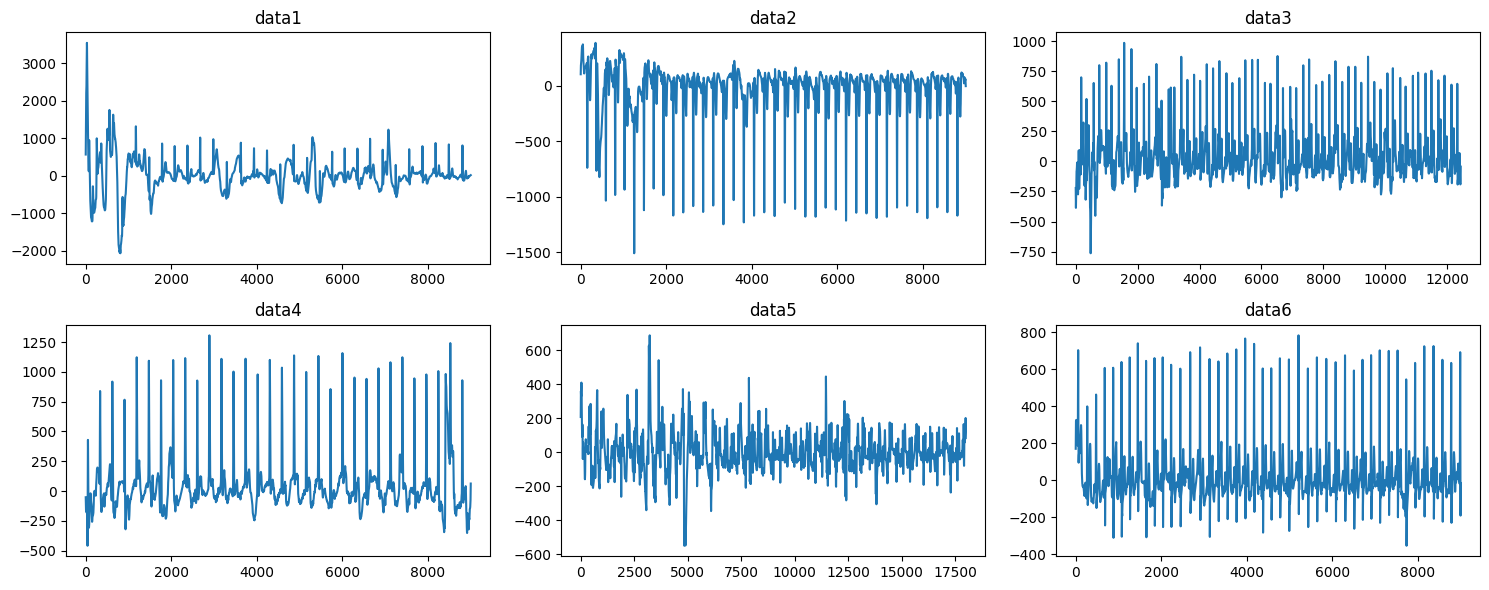

In [8]:
import matplotlib.pyplot as plt
root = "datas/cinc2017"

fig = plt.figure(figsize=(15, 6))  # 創建一個大的圖像容器

for i,path in enumerate(glob.glob(root + '/csv/*')[:6]):
    ax = fig.add_subplot(2, 3, i+1)  # 添加子圖，參數分別為行數、列數、子圖位置
    ax.plot(pd.read_csv(path)['lead']) #讀取csv檔案
    ax.set_title(f"data{i+1}")  # 設定子圖標題

plt.tight_layout()  # 調整子圖之間的間距和布局
plt.show()

In [12]:
x = 0
for path in tqdm.tqdm(glob.glob(root + '/csv/*')):
    signal_length = len(pd.read_csv(path)['lead'])
    if x < signal_length:
        x = signal_length
print(x)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8528/8528 [00:17<00:00, 496.26it/s]

18286


In [13]:
df = pd.read_csv(root + '/REFERENCE-v3.csv',header=None,names=["pat", "label"])


In [14]:
df.head()

,pat,label
0,A00001,N
1,A00002,N
2,A00003,N
3,A00004,A
4,A00005,A


In [15]:
def plotbar(df):
    label_counts = df['label'].value_counts()

    plt.bar(label_counts.index, label_counts.values)
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Bar Chart of Labels')
    plt.show()

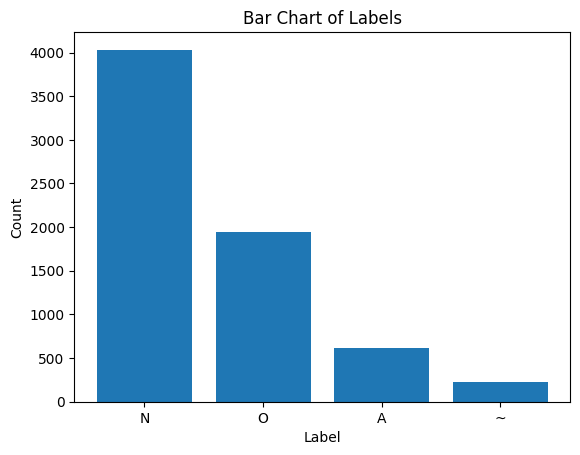

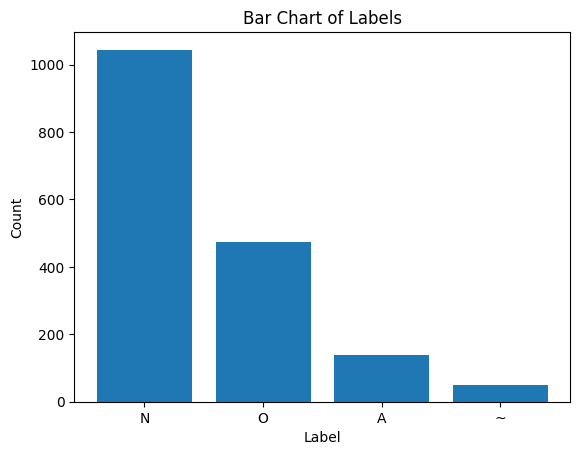

In [16]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
plotbar(train_df)
plotbar(test_df)

In [147]:

class ECGCSVClassificationDataset(Dataset):

    def __init__(self,
                 data_root,
                 label_filename="REFERENCE-v3.csv",
                 channels=["lead"],
                 class_names=["N", "O", "A", "~"],
                 target_length=False):
        """
        Args:
            data_root (str): 資料集的根目錄
            label_filename (str): 標籤檔案的檔名
            channels (list): 目標導程名稱的清單
            class_names (list): 用於將類別名稱映射到類別 ID 的類別名稱清單
        """
        # 讀取標籤檔案並將其儲存在 pandas 的 dataframe 中
        self.df_label = pd.read_csv(os.path.join(data_root, label_filename),
                                    header=None,
                                    names=["pat", "label"])
        # 設定信號檔案儲存的目錄
        self.signal_dir = os.path.join(data_root, "csv")
        # 獲取所有信號檔案的路徑並進行排序
        self.signal_paths = sorted(glob.glob(os.path.join(self.signal_dir, "*.csv")))
        # 建立一個字典來將類別名稱映射到類別 ID
        self.class_map = {n: i for i, n in enumerate(class_names)}
        # 設定資料集的目標導程
        self.channels = channels
        # 設定 padding 長度
        self.target_length = target_length
        print("dataset class map: ", self.class_map)

    def __len__(self):
        return len(self.signal_paths)

    def __getitem__(self, idx):
        # 根據索引從標籤資料中獲取一行
        row = self.df_label.iloc[idx]
        # 從標籤資料中獲取信號檔案的檔名
        signal_filename = row["pat"] + ".csv"
        # 構建信號檔案的完整路徑
        signal_path = os.path.join(self.signal_dir, signal_filename)
        # 讀取信號檔案並將其存儲在一個Pandas DataFrame中
        df_csv = pd.read_csv(signal_path)
        # 獲取 "lead" 列的信號數值
        signal = df_csv["lead"].values

        # 獲取類別名稱
        class_name = row["label"]
        # 根據類別名稱從類別映射中獲取類別 ID
        class_id = self.class_map[class_name]

        # 將信號轉換為 torch 張量並設定數據類型為 float
        signal = torch.tensor(signal, dtype=torch.float)
        # 將類別 ID 轉換為 torch 張量並設定數據類型為 long
        if self.target_length :
            signal = self.pad_sequence(signal)
            
        class_id = torch.tensor(class_id, dtype=torch.long)

        # 預處理信號數據，將其尺寸擴展為 (1, 長度)，以符合模型的輸入要求
        signal = signal.unsqueeze(0)

        return {'signal': signal, 'labels': class_id}
    
    def _check_validate(self):
        assert len(self.df_label) == len(
            self.signal_paths), "csv files and label files are not matched"
        
    # 定義一個名為pad_sequence的函數，接受兩個參數：signal（序列）和target_length（目標長度）
    def pad_sequence(self, signal):  
        # 獲取序列的當前長度
        current_length = len(signal)  

        if current_length >= self.target_length:  # 如果當前長度大於等於目標長度
            return signal[:self.target_length]  # 返回截斷後的序列，保留目標長度內的部分
        else:
            repetitions = self.target_length // current_length  # 計算需要重複的次數
            remainder = self.target_length % current_length  # 計算剩餘需要填充的長度
            repeated_signal = signal.repeat(repetitions)  # 重複訊號
            padded_signal = torch.cat((repeated_signal, signal[:remainder]), dim=0)  # 連接重複的訊號和剩餘部分
            
        return padded_signal  # 返回填充後的序列

In [148]:
ds = ECGCSVClassificationDataset("./data", label_filename="REFERENCE-v3.csv", target_length=18286)


dataset class map:  {'N': 0, 'O': 1, 'A': 2, '~': 3}


In [149]:
ds.__len__()

8528

In [150]:
data = ds[0]


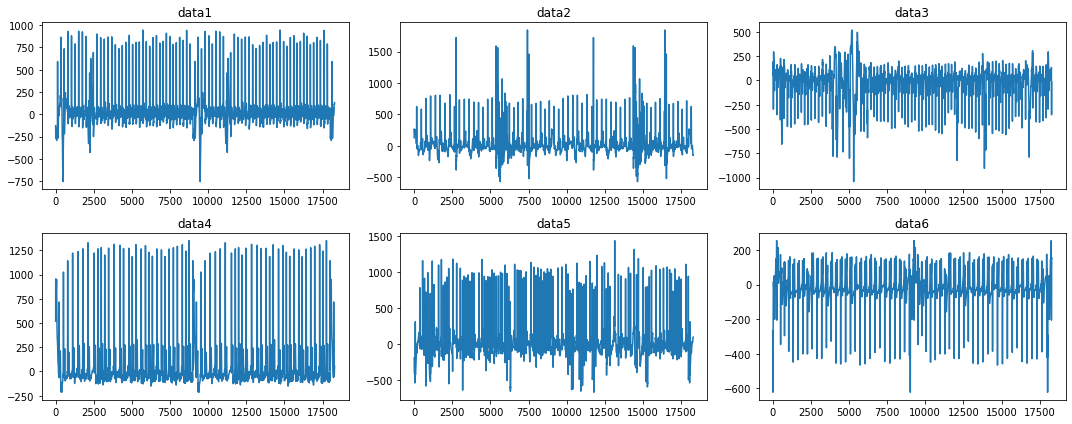

In [151]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 6))  # 創建一個大的圖像容器

for i in range(6):
    ax = fig.add_subplot(2, 3, i+1)  # 添加子圖，參數分別為行數、列數、子圖位置
    ax.plot(ds[i]['signal'].T)
    ax.set_title(f"data{i+1}")  # 設定子圖標題

plt.tight_layout()  # 調整子圖之間的間距和布局
plt.show()

In [17]:
x = 0
for i in tqdm.tqdm_notebook(ds):
    if x < i['signal'].shape[1]:
        x = i['signal'].shape[1]
print(x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8528 [00:00<?, ?it/s]

18286


In [136]:
from torch.utils.data import DataLoader
train_ds = ECGCSVClassificationDataset("./data", label_filename="REFERENCE-v3.csv")

train_dl = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
# val_ds = ECGSegmentationDataset(test_file_list, data_root+'/ECGData', channels=1)
# val_dl = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=4)


dataset class map:  {'N': 0, 'O': 1, 'A': 2, '~': 3}


In [137]:
# from os.path import join
# data_root = '/home/jovyan/ta-shared-ii/datas/a12lead'
# train_file_list = join(data_root,'train_annotations.csv')
# test_file_list = join(data_root,'test_annotations.csv')
# # datafile = join(data_root,'2_0.npy')
# # data = np.load(datafile)
# cfg = Dict(json.load(open(data_root + '/data.cfg') ))  # <---- born data.cfg by self

In [155]:
!pip install xmltodict
!pip install xlwt
!pip install wfdb
!pip install pandas==1.1.5
!pip install einops

  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Using cached pandas-1.1.5-cp37-cp37m-manylinux1_x86_64.whl (9.5 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 4.1.1 requires pandas>=1.3.0, but you have pandas 1.1.5 which is incompatible.


In [158]:
import fusionlab

In [159]:
from fusionlab.classification.vgg import VGG16Classifier
model = VGG16Classifier(spatial_dims=1, cin=1, cout=4) # 指定Model的輸入、輸出層頻道數

In [160]:
model

VGG16Classifier(
  (encoder): VGG16(
    (features): Sequential(
      (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU(inplace=True)
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU(inplace=True)
      (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (6): ReLU(inplace=True)
      (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (8): ReLU(inplace=True)
      (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (11): ReLU(inplace=True)
      (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (13): ReLU(inplace=True)
      (14): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (15): ReLU(inplace=True)
      (16): MaxPool1d(kernel_size=2, strid

In [161]:
from torch import nn
class HFModel(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model=model
#     def forward(self,input_dict):
#         return self._model(input_dict['signal'])
    
    def forward(self, signal, labels):
        logits = self.model(signal)
        
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        return {"logits": logits}
    
my_model = HFModel(model)



In [162]:
my_model

HFModel(
  (model): VGG16Classifier(
    (encoder): VGG16(
      (features): Sequential(
        (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): ReLU(inplace=True)
        (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
        (3): ReLU(inplace=True)
        (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (6): ReLU(inplace=True)
        (7): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (8): ReLU(inplace=True)
        (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (11): ReLU(inplace=True)
        (12): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (13): ReLU(inplace=True)
        (14): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (15): ReLU(

In [167]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # 輸出結果的目錄
    num_train_epochs=10,            # 訓練的 epoch 數量
    per_device_train_batch_size=1,  # 每個訓練 batch 的大小
    save_steps=5000,                # 每隔多少步驟儲存一次模型
    save_total_limit=2,             # 最多儲存幾個模型
    remove_unused_columns=False,
    metric_for_best_model='accuracy',
#     evaluation_strategy='epoch'
    
    
)

trainer = Trainer(
    model=my_model,                     # 要訓練的模型
    args=training_args,              # 訓練的參數
    train_dataset=train_ds,     # 訓練資料集
#     eval_dataset=val_ds,
    #compute_metrics=  # 計算評估指標的函數
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [168]:
from transformers.integrations import MLflowCallback
trainer.remove_callback(MLflowCallback)

trainer.train()

***** Running training *****
  Num examples = 8528
  Num Epochs = 10
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 85280
  Number of trainable parameters = 4909380


Step,Training Loss
500,1.598800
1000,1.669500
1500,1.585100
2000,1.564400
2500,1.624100
3000,1.657300
3500,1.676600
4000,1.596000
4500,1.557600
5000,1.585400


Saving model checkpoint to ./results/checkpoint-5000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-10000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Saving model checkpoint to ./results/checkpoint-15000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Deleting older checkpoint [results/checkpoint-5000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-20000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Deleting older checkpoint [results/checkpoint-10000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-25000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Deleting older checkpoint [results/checkpoint-15000] due to args.save_total_limit
Saving model checkpoint to ./results/checkpoint-30000
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
Deleting old

TrainOutput(global_step=85280, training_loss=1.5602189459451814, metrics={'train_runtime': 1332.8202, 'train_samples_per_second': 63.985, 'train_steps_per_second': 63.985, 'total_flos': 0.0, 'train_loss': 1.5602189459451814, 'epoch': 10.0})

In [62]:
import pandas as pd
pd.read_csv('/home/jovyan/ta-shared-ii/datas/a12lead/MUSE_20180210_125533_00000.csv')

FileNotFoundError: [Errno 2] File /home/jovyan/ta-shared-ii/datas/a12lead/MUSE_20180210_125533_00000.csv does not exist: '/home/jovyan/ta-shared-ii/datas/a12lead/MUSE_20180210_125533_00000.csv'

In [11]:
__all__ = ['read_csv']

def csvread(fname):
    return np.genfromtxt(fname, dtype=np.float32, skip_header=1, delimiter=",")